# Train an image classifier to guess what pokemon is in a picture

We'll need fastai and the huggingface datasets library, so let's install them.

In [6]:
%pip install -Uqq fastai datasets datasets[vision]

zsh:1: no matches found: datasets[vision]


Note: you may need to restart the kernel to use updated packages.


## Load the dataset

We'll use the [Pokemon Images Dataset](https://huggingface.co/datasets/keremberke/pokemon-classification) from HuggingFace datasets library.

In [7]:
from datasets import load_dataset
ds = load_dataset("keremberke/pokemon-classification", name="full")

Found cached dataset pokemon-classification (/Users/simonoob/.cache/huggingface/datasets/keremberke___pokemon-classification/full/1.0.0/5193d0f863ed08164636296506df483caa6c9965bc05198ec2136417398e4b28)


  0%|          | 0/3 [00:00<?, ?it/s]

## Load and inspect an example image object

In [8]:
ds = ds.shuffle()
example = ds['train'][0]

example['image'] = 'the actual image data'

import json

## print the example keys
print(json.dumps(example, indent=2))


{
  "image_file_path": "/Users/simonoob/.cache/huggingface/datasets/downloads/extracted/22d4eb654c67e4b50f18e03b2f4cb7217b5f0fb7fda5beb14b7309203df3424b/Pidgeot/5688c78bd07f4eb8aebe69e2d8a04693_jpg.rf.b40a2c68a2783f29d6d2b624c1be7a04.jpg",
  "image": "the actual image data",
  "labels": 46
}


The labels are stored as numbers, but we want to use the actual names of the pokemon.

We can get the full list from the dataset. 

In [9]:
## get the categories names
labels = ds['train'].features['labels'].names
print(labels)


['Porygon', 'Goldeen', 'Hitmonlee', 'Hitmonchan', 'Gloom', 'Aerodactyl', 'Mankey', 'Seadra', 'Gengar', 'Venonat', 'Articuno', 'Seaking', 'Dugtrio', 'Machop', 'Jynx', 'Oddish', 'Dodrio', 'Dragonair', 'Weedle', 'Golduck', 'Flareon', 'Krabby', 'Parasect', 'Ninetales', 'Nidoqueen', 'Kabutops', 'Drowzee', 'Caterpie', 'Jigglypuff', 'Machamp', 'Clefairy', 'Kangaskhan', 'Dragonite', 'Weepinbell', 'Fearow', 'Bellsprout', 'Grimer', 'Nidorina', 'Staryu', 'Horsea', 'Electabuzz', 'Dratini', 'Machoke', 'Magnemite', 'Squirtle', 'Gyarados', 'Pidgeot', 'Bulbasaur', 'Nidoking', 'Golem', 'Dewgong', 'Moltres', 'Zapdos', 'Poliwrath', 'Vulpix', 'Beedrill', 'Charmander', 'Abra', 'Zubat', 'Golbat', 'Wigglytuff', 'Charizard', 'Slowpoke', 'Poliwag', 'Tentacruel', 'Rhyhorn', 'Onix', 'Butterfree', 'Exeggcute', 'Sandslash', 'Pinsir', 'Rattata', 'Growlithe', 'Haunter', 'Pidgey', 'Ditto', 'Farfetchd', 'Pikachu', 'Raticate', 'Wartortle', 'Vaporeon', 'Cloyster', 'Hypno', 'Arbok', 'Metapod', 'Tangela', 'Kingler', 'Exeg

#### Show the example image and label

Pidgeot


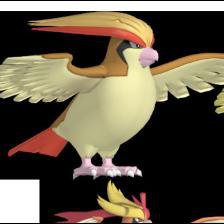

In [10]:
# show example image with label
exampleImagePath = example["image_file_path"]

from fastai.vision.all import *

print(labels[example['labels']])
Image.open(exampleImagePath)




### Now that we know the dataset, let's load it into a `DataBlock` object

define functions to get the list of images and to get the label from the label number

In [104]:
def get_x(o): return o['image_file_path']   # get the image path
def get_y(o): return labels[o['labels']]    # get the label

1. create a datablock object to read the images and labels
1. load the data into a `DataLoaders` object

In [105]:
# blocks
blocks = (ImageBlock, CategoryBlock)

totalTrainingSet = concat(ds['train'], ds['validation'], ds['test'])

# datablock
pokemon = DataBlock(blocks=blocks,
                   get_x=get_x,
                   get_y=get_y,
                   splitter=RandomSplitter(valid_pct=0.2, seed=36),
                   item_tfms=Resize(192, method='squish'))

# dataloader
dls = pokemon.dataloaders(totalTrainingSet, bs=32)

show a batch of data that we will use to train the model

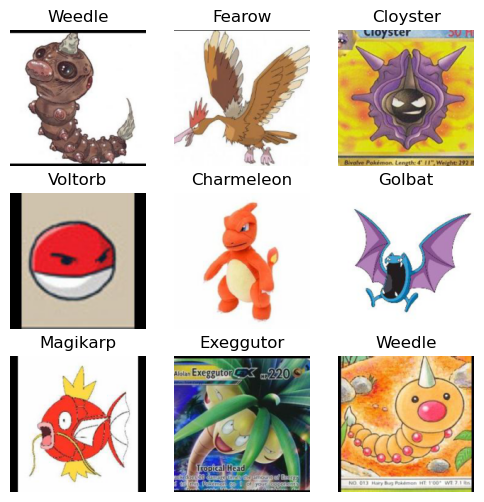

In [106]:
dls.show_batch(max_n=9, figsize=(6,6))

## Train the model

In [112]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Users/simonoob/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/simonoob/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,3.568731,1.608348,0.366237,00:49


epoch,train_loss,valid_loss,error_rate,time
0,1.138793,0.663422,0.153791,01:13
1,0.503305,0.442750,0.114449,01:12
2,0.191676,0.419586,0.111588,01:12


average accuracy of the model on the validation set:

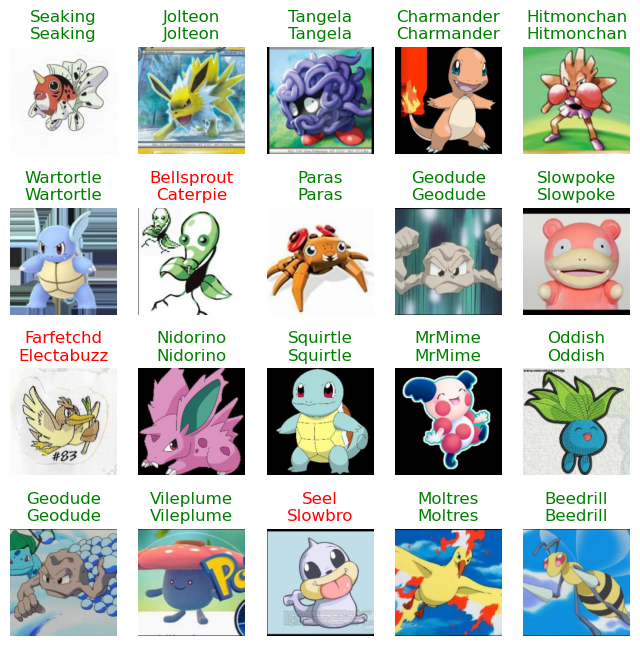

In [117]:
learn.show_results(max_n=20, figsize=(8,8))

## test the trained model with external data

expected result:  Pikachu
-------------------
predicted result:  Pikachu
probablity it is a Pikachu is 0.9992


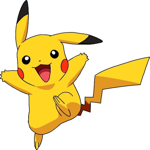

In [ ]:
#download image from the internet and save it to the test.png file
import urllib.request
urllib.request.urlretrieve("https://oyster.ignimgs.com/mediawiki/apis.ign.com/pokemon-blue-version/8/89/Pikachu.jpg", "test.png")

category,_,probs = learn.predict(PILImage.create('test.png'))

print('expected result: ', 'Pikachu')
print('-------------------')
print('predicted result: ', category)
print(f"probablity it is a {category} is {probs.max():.4f}")




Image.open('test.png').resize((150,150))